# **TWEET EXTRACTION**


In [ ]:
!pip install preprocessor

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp37-none-any.whl size=4477 sha256=f750b071982b67e22b682902003bdb0054e3f5fbe51e7bb3f80efb50659b6f38
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor


In [ ]:
#from tweepy import *
#from credentials import *
import tweepy
import csv
import re 
import string
import preprocessor as p
 
consumer_key = "grXPeXzoT1vnh0a5cTs0CaqhS"
consumer_secret = "I42jwatL7GQTpMQ7npe3KV5rr3imh5G4UnGSe1x0IpPI7VhIIT"
access_key= "1306874274133635072-SCaUJwukkkoVav8GModTfvjTo4Vem7"
access_secret = "b0eEcilN828la3imH0pAzAzmwoDpM45HhbcH5kBNVbidW"

In [ ]:
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_key, access_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
resp= tweepy.API(auth)

In [ ]:
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
#THE TWEET SEARCH
search_words = "#TNElection2021"      #enter your words
new_search = search_words + " -filter:retweets"

In [ ]:
csvFile = open('/content/16MDS65Tweets.csv', 'a')
csvWriter = csv.writer(csvFile)

In [ ]:
for tweet in tweepy.Cursor(api.search,q=new_search,count=150,lang="en",since_id=0).items():
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8'),tweet.user.screen_name.encode('utf-8'), tweet.user.location.encode('utf-8')])

In [ ]:
import pandas as pd
df = pd.read_csv('/content/16MDS65Tweets.csv',names=['DATE','TWEET','USER','LOCATION'])
df.head()

,DATE,TWEET,USER,LOCATION
0,01-04-2021 13:37,"b""Hi All, Good Evening. \n\nHere is today's To...",b'tamilgeek_',b'chennai'
1,01-04-2021 12:47,b'There is no anti-incumbency factor against A...,b'samskarebyaha',b'Proud Hindu Nationalist.'
2,01-04-2021 12:40,"b'This #tnelection2021 is not between #ADMK, #...",b'MAAKING08',"b'Lagos, Nigeria'"
3,01-04-2021 12:36,b'@AnandaVikatan Always some guys make some bl...,b'roshanking79797',"b'Chennai,tamilnadu'"
4,01-04-2021 12:29,b'https://t.co/PQB2SrsPfy\n\nWhy to vote ? Who...,b'major_madhan',b'Chennai'


# **TEXT PREPROCESSING**

In [ ]:
!pip install spacy==2.3.5

     |████████████████████████████████| 10.4MB 4.5MB/s 
     |████████████████████████████████| 1.1MB 36.2MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#TO REMOVE DUPLICATE VALUES (IF ANY)
df = df.drop_duplicates()

In [ ]:
#TO CHECK NULL VALUES (IF ANY)
df.isnull().sum()

DATE        0
TWEET       0
USER        0
LOCATION    0
dtype: int64

In [ ]:
#CLEAN UP TWEET EXTRAS
def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags and other quotations
    txt = re.sub(r'&', '', txt)
    txt = re.sub(r'-', '', txt)  
    txt = re.sub(r'#', '', txt) 
    txt = re.sub(r"'", '', txt)
    txt = re.sub(r'"', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    # Remove b"
    txt = re.sub(r'b"', '', txt)
    txt = re.sub(r'\b\w{1,2}\b', '', txt)
    # Remove other unnecessary attributes
    txt = re.sub(r'\\x{1,6}', '', txt)
    txt = re.sub(r'\\{1,6}','',txt)
    txt = re.sub(r'e280a6', '', txt)
    txt = re.sub(r'f09f998f', '', txt)
    return txt

df['TWEET'] = df['TWEET'].apply(cleanUpTweet)

In [ ]:
df = df.drop(columns = ['USER'])
df = df.drop(columns = ['LOCATION'])
df = df.sort_values(by='DATE')

In [ ]:
#GET THE DATASET WITH SUBJECTIVITY AND POLARITY
from textblob import TextBlob
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

df['Subjectivity'] = df['TWEET'].apply(getTextSubjectivity)
df['Polarity'] = df['TWEET'].apply(getTextPolarity)

In [ ]:
#IDENTIFY THE TWEETS SCORE WITH POLARITY
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"

df['Score'] = df['Polarity'].apply(getTextAnalysis)
df

,DATE,TWEET,Subjectivity,Polarity,Score
121,01-04-2021 00:57,"sweep never good for people, okay this t...",0.425000,0.0500,Positive
120,01-04-2021 00:58,bMnm wont win this election but winning few se...,0.337500,0.2750,Positive
119,01-04-2021 01:47,bIt time vote for anyone other than ADMKBJP ...,0.375000,-0.1250,Negative
118,01-04-2021 01:56,bIts said that Telugu Desam party may merge wi...,0.520833,-0.4125,Negative
117,01-04-2021 01:57,bThank You For Joining With BJPnRomba Nalla...,0.000000,0.0000,Neutral
...,...,...,...,...,...
126,31-03-2021 21:41,Best thread recent times. All the memes just...,0.275000,0.5000,Positive
125,31-03-2021 21:42,bBest thread recent times. All the memes just...,0.250000,0.0000,Neutral
124,31-03-2021 23:15,bTNElection2021 PrePoll EPSnADMK alliance 140n...,0.000000,0.0000,Neutral
123,31-03-2021 23:35,bCan repeat what indragandhi and her kins did...,0.000000,0.0000,Neutral


In [ ]:
import nltk
nltk.download('stopwords')
#from nltk.corpus import stopwords
#stopwords.words('english')
def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 
    
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)
       
df.TWEET = df.TWEET.apply(remove_stopwords).apply(remove_mentions)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,DATE,TWEET,Subjectivity,Polarity,Score
121,01-04-2021 00:57,"sweep never good people, okay time someone one...",0.425000,0.0500,Positive
120,01-04-2021 00:58,bMnm wont win election winning seats make big ...,0.337500,0.2750,Positive
119,01-04-2021 01:47,bIt time vote anyone ADMKBJP Alliance TNElecti...,0.375000,-0.1250,Negative
118,01-04-2021 01:56,bIts said Telugu Desam party may merge BJP And...,0.520833,-0.4125,Negative
117,01-04-2021 01:57,bThank You For Joining With BJPnRomba Nalla Pa...,0.000000,0.0000,Neutral
...,...,...,...,...,...
126,31-03-2021 21:41,Best thread recent times. All memes made day. ...,0.275000,0.5000,Positive
125,31-03-2021 21:42,bBest thread recent times. All memes made day....,0.250000,0.0000,Neutral
124,31-03-2021 23:15,bTNElection2021 PrePoll EPSnADMK alliance 140n...,0.000000,0.0000,Neutral
123,31-03-2021 23:35,bCan repeat indragandhi kins did? next Indian ...,0.000000,0.0000,Neutral


In [ ]:
def percentage( data_frame , val ):
  percent = df[df['Score'] == val]
  print(percent.shape[0]/(df.shape[0])*100)

neg = percentage(df , 'Negative')
neu = percentage(df , 'Neutral')
pos = percentage(df , 'Positive')

13.996478873239438
52.72887323943662
33.274647887323944


<BarContainer object of 3 artists>

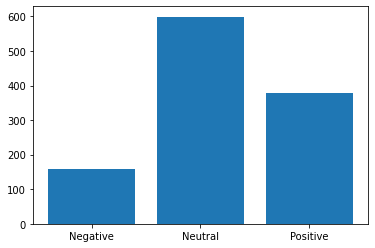

In [ ]:
labels = df.groupby('Score').count().index.values
values = df.groupby('Score').size().values
plt.bar(labels, values)

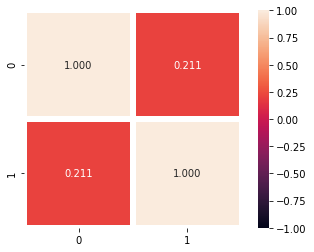

In [ ]:
import numpy as np
import seaborn as sn
#correlation
correl = np.corrcoef(df.Subjectivity,	df.Polarity)
sn.heatmap(correl, annot = True, fmt = ".3f", linewidths=5, vmin = -1, vmax = 1, square = True)
plt.show()

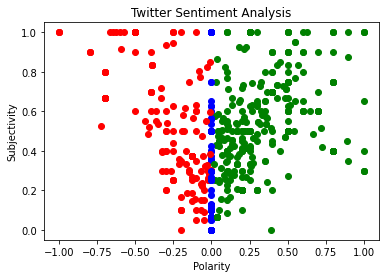

In [ ]:
for index, row in df.iterrows():
    if row['Score'] == 'Positive':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="green")
    elif row['Score'] == 'Negative':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="red")
    elif row['Score'] == 'Neutral':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="blue")

plt.title('Twitter Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
# add legend
plt.show()

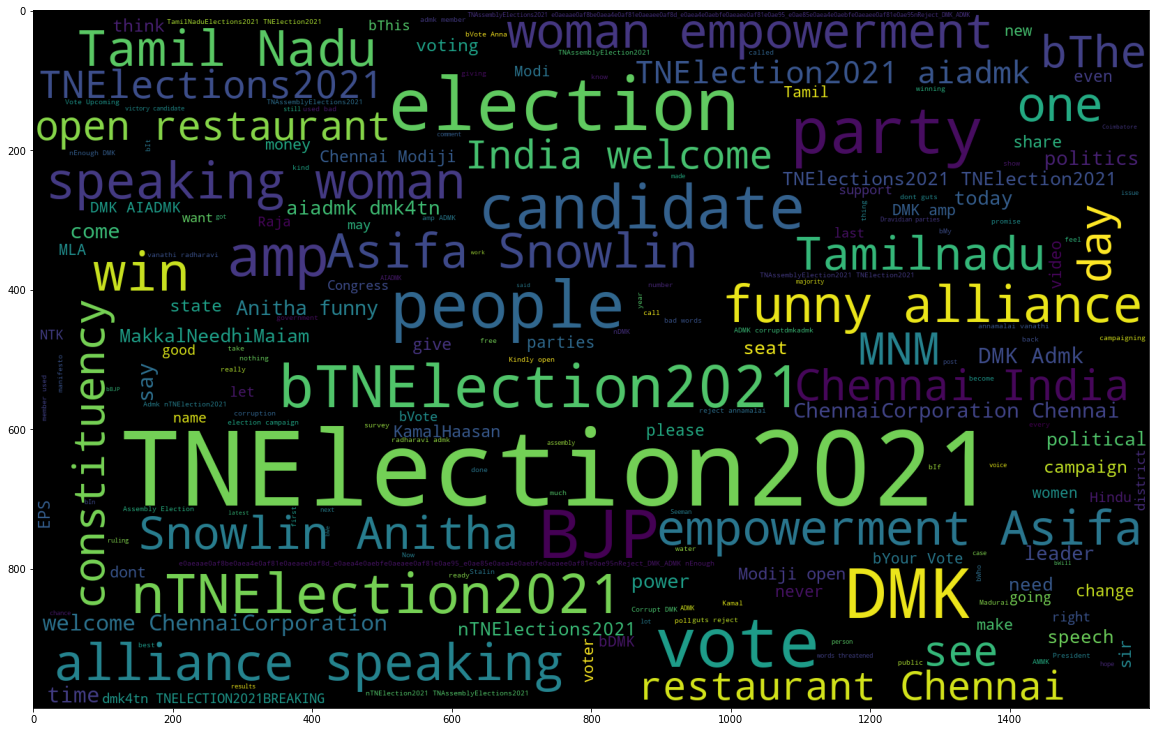

In [ ]:
words = ' '.join([tweet for tweet in df['TWEET']])
plt.figure(figsize = (20,20) )
wordCloud = WordCloud(width=1600, height=1000, max_font_size = 150).generate(words)
#max_words = 75,
plt.imshow(wordCloud)
plt.show()

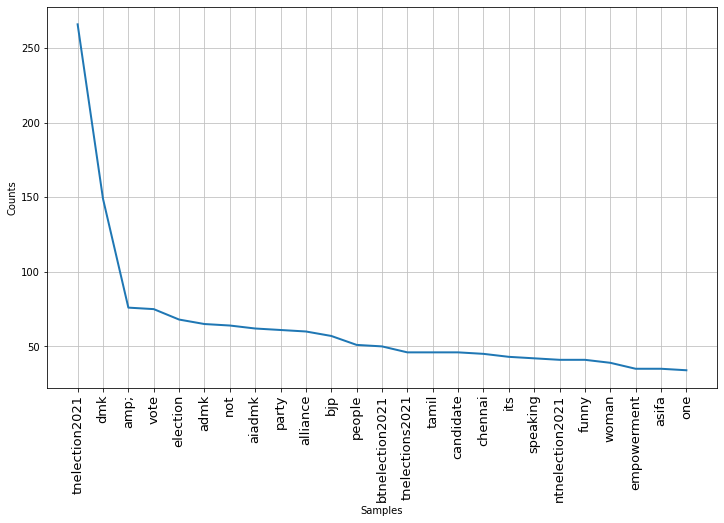

In [ ]:
from collections import Counter
import nltk
# most common words in twitter dataset
all_words = []
for line in list(df['TWEET']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,7))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [ ]:
lens = df['TWEET'].str.len()
print(lens.mean())

82.18485915492958


In [ ]:
#import plotly.express as px
#nltk.download('punkt')
#len1 = [ len(nltk.word_tokenize(tweet)) for tweet in df['TWEET'] ]
#fig = px.histogram(x = len1, nbins = 50)
#fig.show()

# **MACHINE LEARNING**

In [ ]:
X = df.TWEET
y = pd.get_dummies(df.Score)
#df["Score"]= df['Score'].replace('Negative', '-1')
#df['Score']= df['Score'].replace('Neutral', '0')
#df['Score']= df['Score'].replace('Positive', '1')
y = df.Score

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=10, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 4), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = 'english')
tfv.fit(x_test)
X_train = tfv.transform(x_train)
X_test = tfv.transform(x_test)

LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(penalty='l2', 
                               dual=False, 
                               tol=0.0001, 
                               C=1, 
                               fit_intercept=True, 
                               intercept_scaling=1.0, 
                               class_weight=None, 
                               random_state=None)

#LogisticRegression(C=1, penalty='l1', solver='liblinear')

model.fit(X_test, y_test)
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
print('Train Accuracy:', accuracy_score(y_train, predictions_train)*100)
print('Test Accuracy:', accuracy_score(y_test, predictions_test)*100)

Train Accuracy: 51.431718061674005
Test Accuracy: 61.8421052631579


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test,predictions_test)
print(cm)
cf = classification_report(y_test,predictions_test)
print(cf)
#accuracy_score(y_test,predictions_test)

[[10 12 11]
 [ 3 78 28]
 [ 1 32 53]]
              precision    recall  f1-score   support

    Negative       0.71      0.30      0.43        33
     Neutral       0.64      0.72      0.68       109
    Positive       0.58      0.62      0.60        86

    accuracy                           0.62       228
   macro avg       0.64      0.54      0.57       228
weighted avg       0.63      0.62      0.61       228



MULTINOMIAL NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
predictions_train1 = model.predict(X_train) 
predictions_test1 = model.predict(X_test)
print('Train Accuracy:', accuracy_score(y_train, predictions_train1)*100)
print('Test Accuracy:', accuracy_score(y_test, predictions_test1)*100)

Train Accuracy: 57.819383259911895
Test Accuracy: 53.50877192982456


In [ ]:
cm1 = confusion_matrix(y_test,predictions_test1)
cr1 = classification_report(y_test,predictions_test)
print(cm1)
print(cr1)

[[  3  30   0]
 [  1 106   2]
 [  1  72  13]]
              precision    recall  f1-score   support

    Negative       0.71      0.30      0.43        33
     Neutral       0.64      0.72      0.68       109
    Positive       0.58      0.62      0.60        86

    accuracy                           0.62       228
   macro avg       0.64      0.54      0.57       228
weighted avg       0.63      0.62      0.61       228



TF-ID VECTORIZER

In [ ]:
vectorizer = TfidfVectorizer(min_df=2)
train_term = vectorizer.fit_transform(x_train)
test_term = vectorizer.transform(x_test)
#vectorizer.get_feature_names()[:20]

#X_train
model1 = MultinomialNB()
model1.fit(train_term, y_train)
predictions_train2 = model1.predict(train_term)
predictions_test2 = model1.predict(test_term)
print('Train Accuracy:', accuracy_score(y_train, predictions_train2)*100)
print('Test Accuracy:', accuracy_score(y_test, predictions_test2)*100)

Train Accuracy: 80.50660792951541
Test Accuracy: 67.10526315789474


In [ ]:
cm2 = confusion_matrix(y_test, predictions_test2)
cr2 = classification_report(y_test, predictions_test2)
print(cm2)
print(cr2)

[[  7  24   2]
 [  0 106   3]
 [  0  46  40]]
              precision    recall  f1-score   support

    Negative       1.00      0.21      0.35        33
     Neutral       0.60      0.97      0.74       109
    Positive       0.89      0.47      0.61        86

    accuracy                           0.67       228
   macro avg       0.83      0.55      0.57       228
weighted avg       0.77      0.67      0.64       228



DECISION TREE CLASSIFIER

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
model3 = classifier.fit(X_train, y_train)
predictions_train3 = model3.predict(X_train)
predictions_test3 = model3.predict(X_test)
print('Train Accuracy:', accuracy_score(y_train, predictions_train3)*100)
print('Test Accuracy:', accuracy_score(y_test, predictions_test3)*100)

Train Accuracy: 66.62995594713657
Test Accuracy: 55.26315789473685


In [ ]:
cm3 = confusion_matrix(y_test, predictions_test3)
cr3 = classification_report(y_test, predictions_test3)
print(cm3)
print(cr3)

[[ 7 22  4]
 [ 6 91 12]
 [ 3 55 28]]
              precision    recall  f1-score   support

    Negative       0.44      0.21      0.29        33
     Neutral       0.54      0.83      0.66       109
    Positive       0.64      0.33      0.43        86

    accuracy                           0.55       228
   macro avg       0.54      0.46      0.46       228
weighted avg       0.56      0.55      0.52       228



SVC

In [ ]:
from sklearn.svm import SVC
svc_ml = SVC(kernel = 'linear', random_state = 0)
model4 = svc_ml.fit(X_train, y_train)
predictions_train4 = model4.predict(X_train)
predictions_test4 = model4.predict(X_test)
print('Train Accuracy:', accuracy_score(y_train, predictions_train4)*100)
print('Test Accuracy:', accuracy_score(y_test, predictions_test4)*100)

Train Accuracy: 57.48898678414097
Test Accuracy: 52.63157894736842


In [ ]:
cm4 = confusion_matrix(y_test, predictions_test4)
cr4 = classification_report(y_test, predictions_test4)
print(cm4)
print(cr4)

[[  0  33   0]
 [  0 109   0]
 [  0  75  11]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        33
     Neutral       0.50      1.00      0.67       109
    Positive       1.00      0.13      0.23        86

    accuracy                           0.53       228
   macro avg       0.50      0.38      0.30       228
weighted avg       0.62      0.53      0.41       228



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
